In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/quickdraw_data/'

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torch import nn, optim
from torchvision import transforms, datasets

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
data_dirs = {
    'train': dataset_path+'train/',
    'valid': dataset_path+'valid/',
    'test': dataset_path+'test/',
}

In [ ]:
data_dirs

{'test': '/content/drive/My Drive/quickdraw_data/test/',
 'train': '/content/drive/My Drive/quickdraw_data/train/',
 'valid': '/content/drive/My Drive/quickdraw_data/valid/'}

In [ ]:
data_dirs['train']

'/content/drive/My Drive/quickdraw_data/train/'

In [ ]:
files = os.listdir(data_dirs['train'])
files = files[:10]
idx_to_class = sorted([f.split('_')[-1].split('.')[0] for f in files])

class_to_idx = {idx_to_class[i]: i for i in range(len(idx_to_class))}


In [ ]:
files

['full_numpy_bitmap_The Eiffel Tower.npy',
 'full_numpy_bitmap_airplane.npy',
 'full_numpy_bitmap_alarm clock.npy',
 'full_numpy_bitmap_ant.npy',
 'full_numpy_bitmap_apple.npy',
 'full_numpy_bitmap_basketball.npy',
 'full_numpy_bitmap_camera.npy',
 'full_numpy_bitmap_dog.npy',
 'full_numpy_bitmap_car.npy',
 'full_numpy_bitmap_banana.npy']

In [ ]:
class_to_idx

{'The Eiffel Tower': 0,
 'airplane': 1,
 'alarm clock': 2,
 'ant': 3,
 'apple': 4,
 'banana': 5,
 'basketball': 6,
 'camera': 7,
 'car': 8,
 'dog': 9}

In [ ]:
idx_to_class

['The Eiffel Tower',
 'airplane',
 'alarm clock',
 'ant',
 'apple',
 'banana',
 'basketball',
 'camera',
 'car',
 'dog']

In [ ]:
len(idx_to_class)

10

In [ ]:
# data transform block
data_transform = {
    'train' : transforms.Compose([
                                  transforms.RandomRotation(10),
                                  transforms.ToTensor()
    ]),

    'valid' : transforms.Compose([
                                  transforms.ToTensor()
    ]),
 
    'test' : transforms.Compose([
                                 transforms.ToTensor()
    ])

}

In [ ]:
data_transform['train']

Compose(
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

In [ ]:
# dataset block
dataset = {}

for d in ['train', 'valid', 'test']:
    data_x = []
    data_y = []

    for path, _, temp in os.walk(data_dirs[d]):
      for f in files:
        c = f.split('_')[-1].split('.')[0] # get class name from file name
        x = np.load(path + f).reshape(-1, 28, 28) / 255
        y = np.ones((len(x), 1), dtype=np.int64) * class_to_idx[c]

        data_x.extend(x)
        data_y.extend(y)

      dataset[d] = torch.utils.data.TensorDataset(torch.stack([data_transform[d](Image.fromarray(np.uint8(i*255))) for i in data_x]), 
                                                torch.stack([torch.Tensor(j) for j in data_y]))

In [ ]:
[len(dataset[d]) for d in ['train', 'valid', 'test']]


[196000, 84000, 70000]

In [ ]:
#batch size
bs = 128

In [ ]:
dataloaders = {
    d: torch.utils.data.DataLoader(dataset[d], batch_size=bs, shuffle=True) for d in ['train', 
                                                                                      'valid', 
                                                                                      'test']
}

In [ ]:
len(dataloaders['train'])

1532

In [ ]:
for data_idx, (data,target) in enumerate(dataloaders['test']):
  print(data.shape)
  if data_idx==4:
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


In [ ]:

invTrans = transforms.Compose([ transforms.Normalize([0.],[1/0.316]),
                                transforms.Normalize([-0.155],[1.]),
                               ])

def imshow(img):
#     img = invTrans(img)
#     img = img.numpy()
    plt.imshow(img.reshape(28,28), cmap='gray')

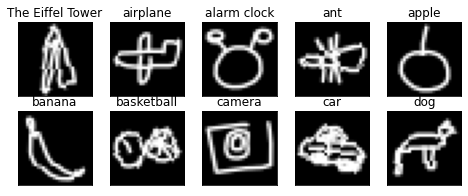

In [ ]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(8, 3))
# display 9 images
for cls in np.arange(10):
    ax = fig.add_subplot(2, 5, cls+1, xticks=[], yticks=[])
    
    image = images.numpy()[labels.numpy().reshape(-1) == cls][0]
    label = labels.numpy()[labels.numpy().reshape(-1) == cls][0, 0].astype(np.int64)
    imshow(image)
    ax.set_title(idx_to_class[label])
plt.savefig('data_vis_small.png')

In [ ]:
dataiter = iter(dataloaders['train'])
image, label = dataiter.next()


In [ ]:
type(image[0])

NameError: ignored

In [ ]:
#CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(5, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*16, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 10)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [ ]:
model_scratch = Net()
model_scratch.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [ ]:
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 0.001)

In [ ]:
cd models

[Errno 2] No such file or directory: 'models'
/content


In [ ]:
# train and validate cycle
def train(epochs, loaders, model, optimizer, criterion, device, save_path):
    """
    epochs : number of epochs
    loaders : dataloaders that we define!
    model : CNN model 
    optimizer : Adam Optimizer
    criterion : crossEntropy
    device : prefer CUDA
    save_path : model folder

    takes these arguments and returns the model, and losses.
    """

    #pointer for min validation loss
    valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []

    for epoch in range(1,epochs+1):
        #pointer 
        train_loss =  0.0
        valid_loss = 0.0

        #model in training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            #move to GPU
            data, target = data.to(device) , target.long().to(device)

            #5 steps
            optimizer.zero_grad() # make sure's grads don't pile up
            output = model(data) # predictions
            loss = criterion(output, torch.max(target,1)[0]) #loss
            loss.backward() #backward propagation
            optimizer.step() #updation!

            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            #model in validation mode
            model.eval()
        for batch_idx, (data,target) in enumerate(loaders['valid']):
            # move to GPU
            data, target = data.to(device), target.long().to(device)
            
            #update average val loss
            output = model(data)
            loss = criterion(output,torch.max(target,1)[0])
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        #print stats
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(    
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)

        if valid_loss < valid_loss_min:
          print('Saving model, model saved....')
          valid_loss_min = valid_loss
          torch.save(model.state_dict(), save_path)

    #finally return model
    return model, train_losses, val_losses

In [ ]:
ls

In [ ]:
# train the model
model_scratch, train_losses, val_losses = train(25, dataloaders, model_scratch, optimizer_scratch, 
                                                criterion_scratch, device, 'mark1_25.pt')

Epoch: 1 	Training Loss: 0.560867 	Validation Loss: 0.396798
Saving model, model saved....
Epoch: 2 	Training Loss: 0.365212 	Validation Loss: 0.325163
Saving model, model saved....
Epoch: 3 	Training Loss: 0.309063 	Validation Loss: 0.291169
Saving model, model saved....
Epoch: 4 	Training Loss: 0.279498 	Validation Loss: 0.275433
Saving model, model saved....
Epoch: 5 	Training Loss: 0.259729 	Validation Loss: 0.255984
Saving model, model saved....
Epoch: 6 	Training Loss: 0.243842 	Validation Loss: 0.266013
Epoch: 7 	Training Loss: 0.231772 	Validation Loss: 0.259593
Epoch: 8 	Training Loss: 0.221417 	Validation Loss: 0.244017
Saving model, model saved....
Epoch: 9 	Training Loss: 0.212144 	Validation Loss: 0.250247
Epoch: 10 	Training Loss: 0.203718 	Validation Loss: 0.237473
Saving model, model saved....
Epoch: 11 	Training Loss: 0.196576 	Validation Loss: 0.244968
Epoch: 12 	Training Loss: 0.189714 	Validation Loss: 0.242504
Epoch: 13 	Training Loss: 0.183253 	Validation Loss: 0.

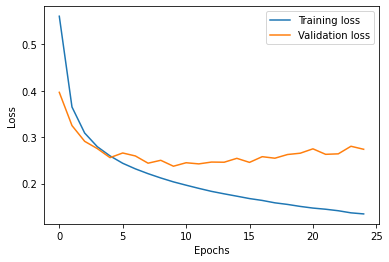

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xticks([i for i in range(0, len(train_losses), 5)].append(len(train_losses)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
plt.show()

In [ ]:
#load the model
model_scratch.load_state_dict(torch.load('mark1_25.pt'))


<All keys matched successfully>

In [ ]:

def mapk(target, output, k=3):
    map_sum = 0
    output = torch.topk(output, k)[1]
    for i, t in enumerate(target):
        idx = (output[i] == t).nonzero().cpu().numpy()
        if len(idx) == 0:
            continue
            
        idx = idx[0][0]
        map_sum += 1 / (idx + 1)
        
    return map_sum

In [ ]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    total_mapk = 0
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.long().to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target.view(-1))
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
            probs = output.data.cpu().numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            probs = np.vstack([probs, output.data.cpu().numpy()])
            
        total_mapk += mapk(target, output)
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    map3 = np.around(total_mapk / len(loaders["test"].dataset) * 100, 2)
    print(f'\nMean Average Precision @ 3: {map3}%')
          
    return y, y_hat, probs

In [ ]:
y, y_hat, probs = test(dataloaders, model_scratch, criterion_scratch, device)

Test Loss: 0.239746


Test Accuracy: 92% (64794/70000)

Mean Average Precision @ 3: 95.11%


In [ ]:
def cmc_curve(probs, y, idx_to_class):
    counts = np.zeros(len(idx_to_class))
    
    indices = np.argsort(probs * -1)
    for i in range(y.shape[0]):
        actual = y[i]
        rank = 1
        for pred in indices[i]:
            if pred == actual:
                break
            rank += 1
        
        counts[rank - 1] += 1
    
    ranks = np.zeros(len(idx_to_class))
    ranks[0] = counts[0]
    for i in range(1, len(idx_to_class)):
        ranks[i] = ranks[i-1] + counts[i]

    return ranks / y.shape[0]

In [ ]:
cmcs = cmc_curve(probs, y, idx_to_class)


In [ ]:
cmcs_lda_3 = [0.91458333, 0.95911111, 0.97458333, 0.98288889, 0.98794444, 0.99166667,
 0.99483333, 0.99686111, 0.99872222, 1.]

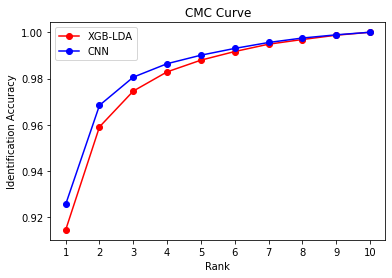

In [ ]:
plt.plot([i for i in range(1,11)], cmcs_lda_3, 'bo-', label='XGB-LDA', c='r')
plt.plot([i for i in range(1,11)], cmcs, 'bo-', label='CNN')
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Rank')
plt.ylabel('Identification Accuracy')
plt.title('CMC Curve')
plt.legend()
plt.savefig('cmc_small.png')
plt.show()

In [ ]:
def confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()


In [ ]:
def accuracy(y, y_hat):
    """
    y [np array]: actual labels
    y_hat [np array]: predicted labels
    
    return: accuracy between 0 and 1
    """
    return np.sum(y == y_hat) / len(y)

In [ ]:
accuracy(y, y_hat)


0.9256285714285715

In [ ]:
cm = confusion_matrix(y, y_hat, nclasses=len(idx_to_class))


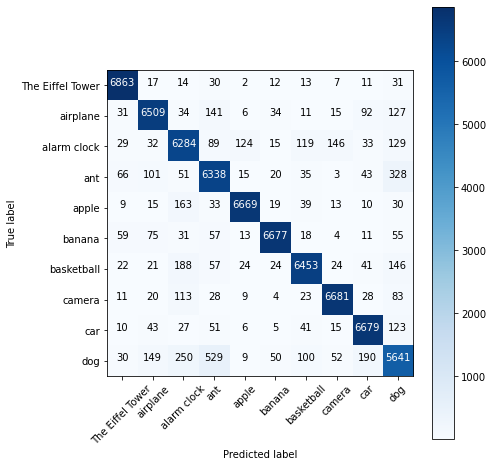

In [ ]:
import itertools
confusion_matrix(cm, idx_to_class, title='',
                           filename='Confusion Matrix with CNN from mark1_25 model', figsize=(7,7), path='./')

In [ ]:
# train the model
model_scratch, train_losses, val_losses = train(50, dataloaders, model_scratch, optimizer_scratch, 
                                                criterion_scratch, device, 'mark2_50.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 0.756313 	Validation Loss: 0.497015
Saving model, model saved....
Epoch: 2 	Training Loss: 0.444849 	Validation Loss: 0.366475
Saving model, model saved....
Epoch: 3 	Training Loss: 0.364771 	Validation Loss: 0.326878
Saving model, model saved....
Epoch: 4 	Training Loss: 0.323583 	Validation Loss: 0.302439
Saving model, model saved....
Epoch: 5 	Training Loss: 0.298621 	Validation Loss: 0.300663
Saving model, model saved....
Epoch: 6 	Training Loss: 0.282489 	Validation Loss: 0.278512
Saving model, model saved....
Epoch: 7 	Training Loss: 0.268950 	Validation Loss: 0.267017
Saving model, model saved....
Epoch: 8 	Training Loss: 0.257888 	Validation Loss: 0.269994
Epoch: 9 	Training Loss: 0.248139 	Validation Loss: 0.259697
Saving model, model saved....
Epoch: 10 	Training Loss: 0.240727 	Validation Loss: 0.261768
Epoch: 11 	Training Loss: 0.233101 	Validation Loss: 0.259992
Epoch: 12 	Training Loss: 0.225948 	Validation Loss: 0.280163
Epoch: 13 	Training Loss: